In [127]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.cm as cm
import geopandas as gpd
import matplotlib.pyplot as plt

# Load, clean, feature clip and standardize the data

In [128]:
# Load the dataset
df = pd.read_csv("country_data.csv")
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [129]:
df.shape

(167, 10)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [131]:
# Check for duplicated rows
df.duplicated().sum()

np.int64(0)

In [132]:
# Check for null values
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

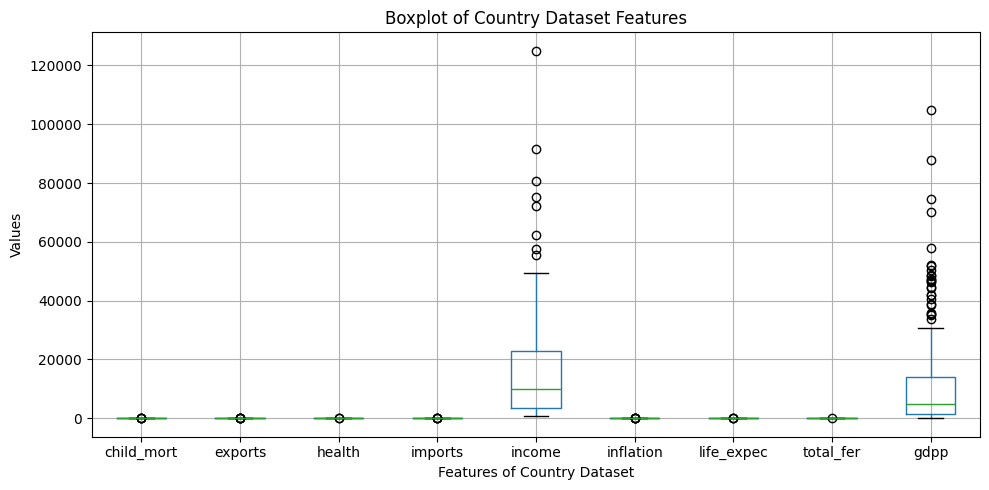

In [133]:
# Boxplot of the dataset to spot outliers
df.boxplot(figsize=(10,5))

# Add title and labels
plt.title('Boxplot of Country Dataset Features')
plt.xlabel('Features of Country Dataset')
plt.ylabel('Values')

plt.tight_layout()
plt.show()

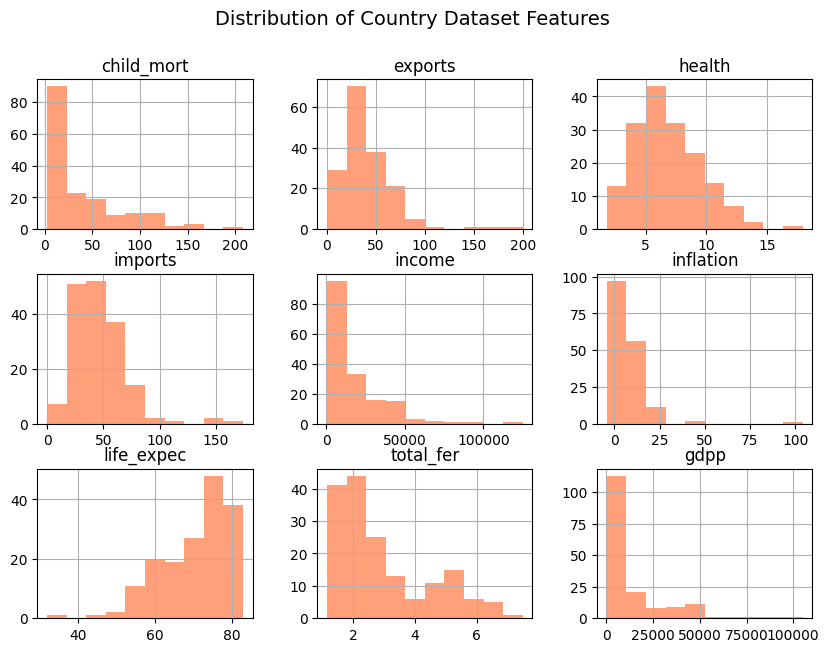

In [134]:
# Histogram of the dataset
df.hist(bins=10, color='#FFA07A', figsize=(10,7))

# Add title
plt.suptitle('Distribution of Country Dataset Features', fontsize=14)

plt.show()

In [135]:
# Feature clipping right skewed features
# Define list of right skewed featutres
features = ['gdpp', 'income', 'child_mort', 'exports', 'imports', 'inflation']

# Feature clip
for feature in features:
    lower_limit, upper_limit = np.percentile(df[feature], [1,95])
    df[feature] = np.clip(df[feature], lower_limit, upper_limit)

# Feature clipping left skewed features
lower_limit, upper_limit = np.percentile(df['life_expec'], [5,100])
df['life_expec'] = np.clip(df['life_expec'], lower_limit, upper_limit)

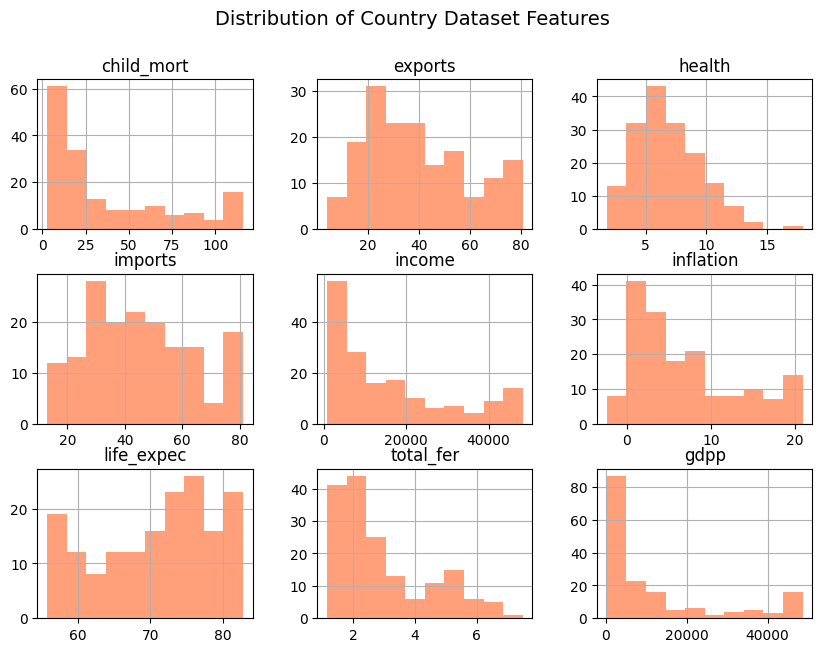

In [136]:
# Histogram of the dataset
df.hist(bins=10, color='#FFA07A', figsize=(10,7))

# Add title
plt.suptitle('Distribution of Country Dataset Features', fontsize=14)

plt.show()

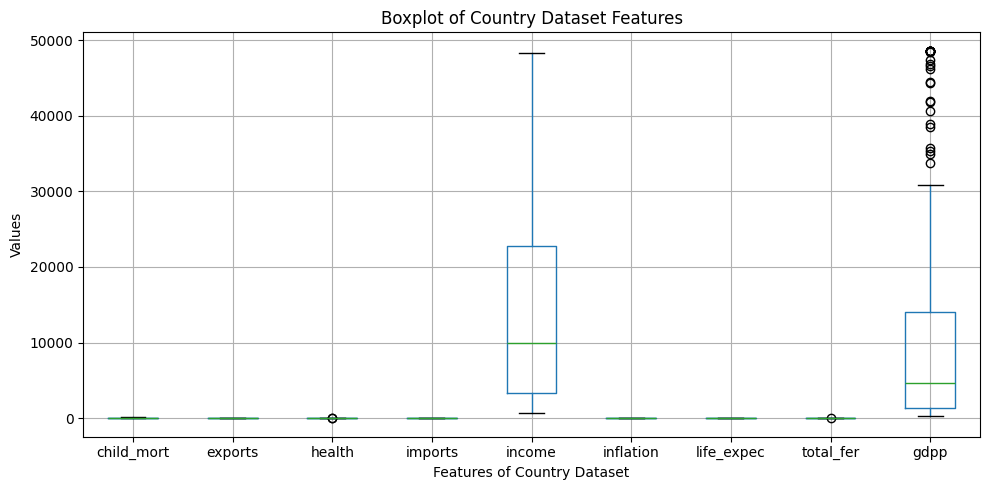

In [137]:
# Boxplot of the dataset to re-check outliers
df.boxplot(figsize=(10,5))

# Add title and labels
plt.title('Boxplot of Country Dataset Features')
plt.xlabel('Features of Country Dataset')
plt.ylabel('Values')

plt.tight_layout()
plt.show()

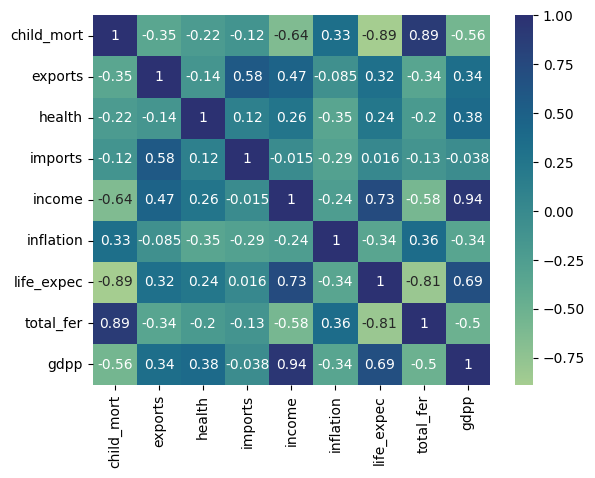

In [138]:
# Features Heapmap to check for for correlation
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='crest')
plt.show()

In [139]:
# Scale the features using Robust Scaler
features = df[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [140]:
# Finding the k value
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(scaled_features)
    sse.append(km.inertia_)

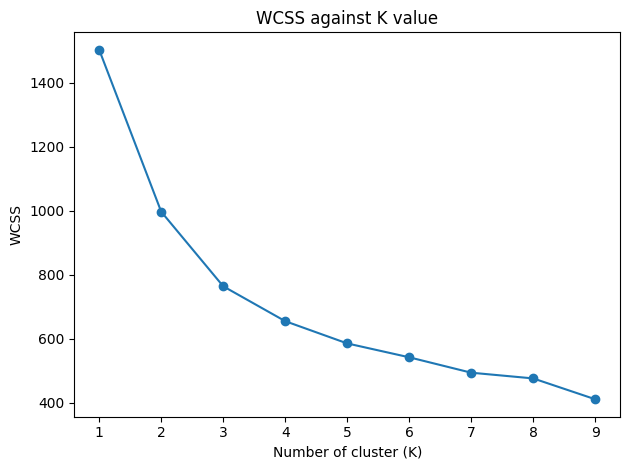

In [141]:
# Plot
plt.plot(k_rng, sse, marker='o')
plt.xlabel('Number of cluster (K)')
plt.ylabel('WCSS')
plt.title('WCSS against K value')
plt.tight_layout()
plt.show()

For n_clusters = 2, average silhouette score = 0.284


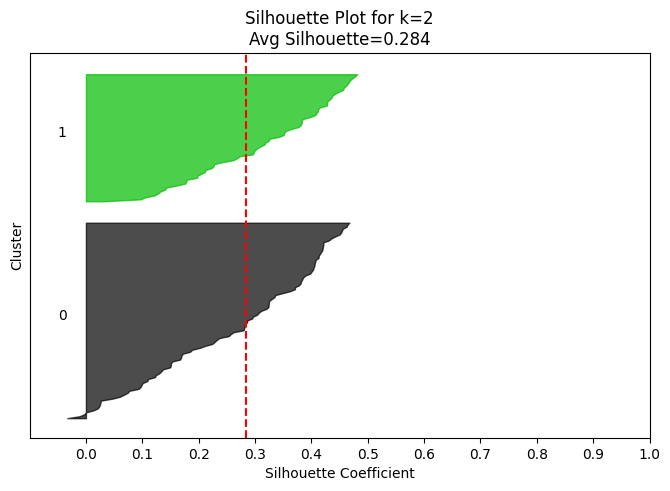

For n_clusters = 3, average silhouette score = 0.273


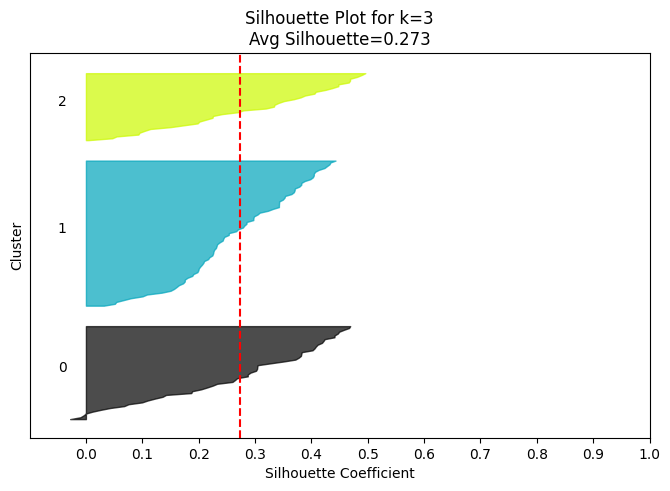

For n_clusters = 4, average silhouette score = 0.268


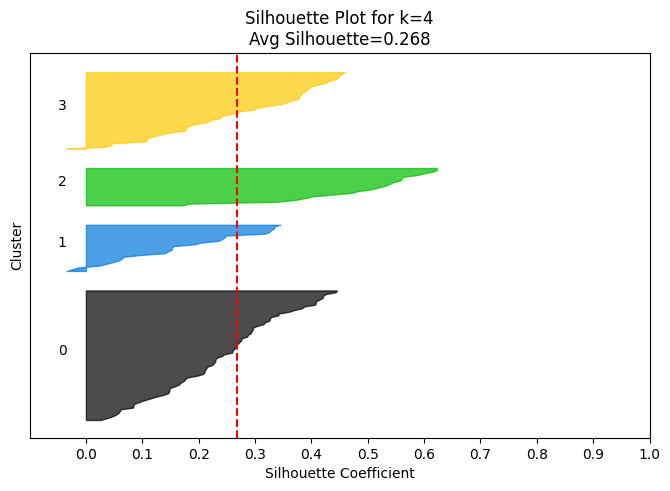

For n_clusters = 5, average silhouette score = 0.258


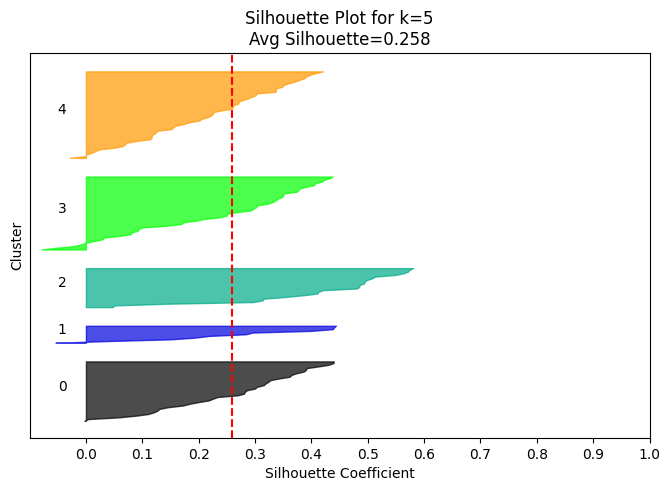

For n_clusters = 6, average silhouette score = 0.250


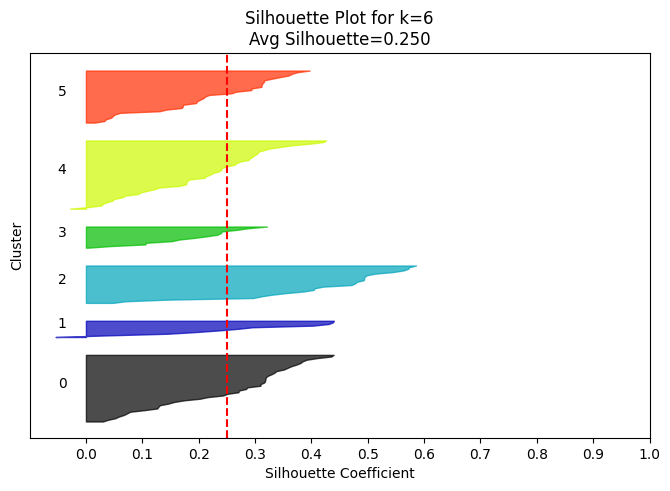

In [142]:
# Visualize Silhoutte scores to to see how well balanced scores are in each of the clusters (for different K value)
# Silhoutte score of closer to 1 is better

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Initialise the clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(scaled_features)
    
    # Average silhouette score
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    print(f"For n_clusters = {n_clusters}, average silhouette score = {silhouette_avg:.3f}")
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(scaled_features, cluster_labels)
    
    # Create a subplot for silhouette
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 5)
    
    # The silhouette coefficient range 
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(scaled_features) + (n_clusters + 1) * 10])
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate silhouette scores for samples in cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )
        
        # Label the silhouette plots with their cluster number at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute new y_lower for next cluster
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Visualise silhouette score for each K value
    ax1.set_title(f"Silhouette Plot for k={n_clusters}\nAvg Silhouette={silhouette_avg:.3f}")
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_ylabel("Cluster")
    
    # The vertical line for average silhouette score of all values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # Clear the y-axis labels
    ax1.set_yticks([])  
    ax1.set_xticks([i/10 for i in range(0, 11)])
    
    plt.show()
    



In [143]:
# Dimensionality reduction
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(scaled_features)

In [144]:
# Use the cluster to be 3
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(reduced_data)
y_predicted

array([1, 2, 2, 1, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 1, 2, 2, 0, 2,
       2, 2, 0, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 2, 0, 1, 0, 0, 0,
       0, 2, 2, 2, 2, 2, 1, 0, 2, 0, 0, 2, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2,
       1, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 0, 0, 1,
       1, 2, 0, 0, 2, 1, 1, 2, 0, 1, 0, 1, 0, 1, 2, 2, 0, 2, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 2, 0, 0, 0, 2, 2, 1, 2, 2, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 2, 0, 0, 1, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1], dtype=int32)

In [145]:
# put the cluster into the dataframe
df['Cluster'] = y_predicted

df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.20,5.82,553.0,1
1,Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.30,1.65,4090.0,2
2,Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.50,2.89,4460.0,2
3,Angola,116.0,62.3,2.85,42.9,5900.0,20.87,60.10,6.16,3530.0,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.80,2.13,12200.0,0
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950.0,2.62,63.00,3.50,2970.0,2
163,Venezuela,17.1,28.5,4.91,17.6,16500.0,20.87,75.40,2.47,13500.0,2
164,Vietnam,23.3,72.0,6.84,80.2,4490.0,12.10,73.10,1.95,1310.0,2
165,Yemen,56.3,30.0,5.18,34.4,4480.0,20.87,67.50,4.67,1310.0,1


In [146]:
# Centroid
km.cluster_centers_

array([[ 2.39412072, -0.032722  ,  0.29290465],
       [-2.55816165, -0.09748181,  0.46850305],
       [-0.13710487,  0.09619141, -0.57328022]])

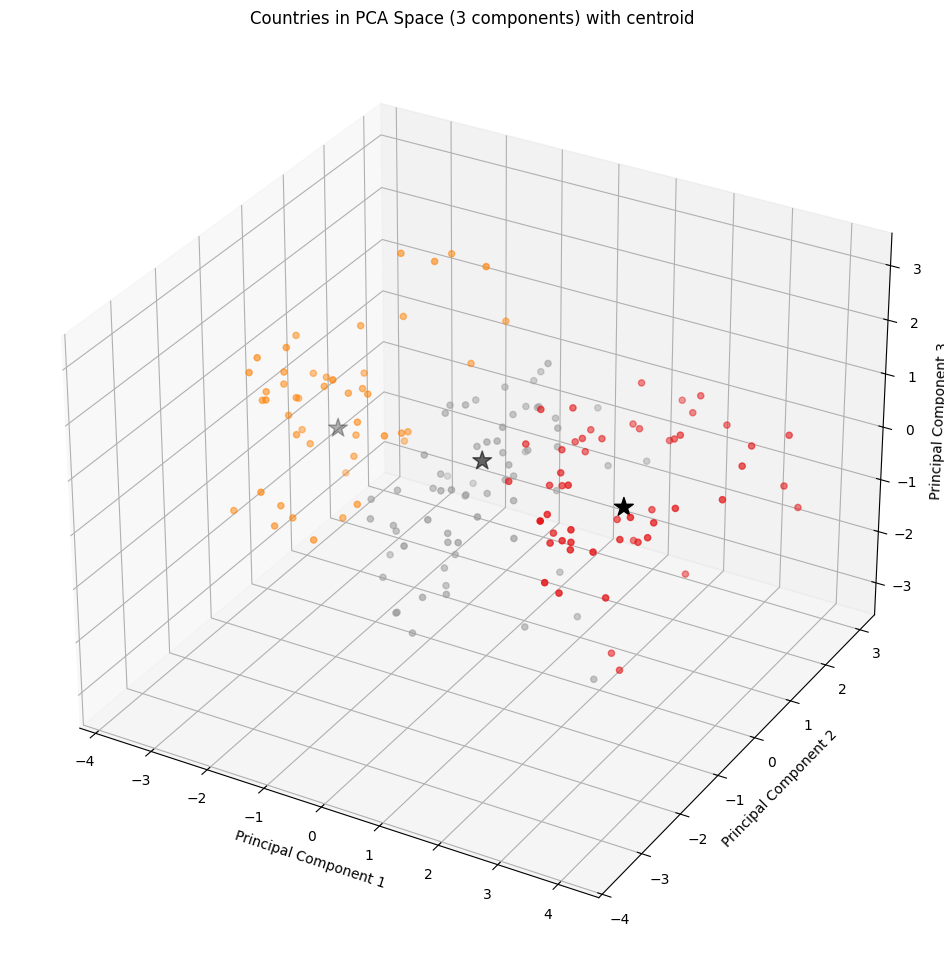

In [147]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot in 3D
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df["Cluster"], cmap="Set1", label='Clusters')

# Plot centroids
ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], color = 'black', marker='*', s=200, label = 'Centroids')

# Add title and labels
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.title("Countries in PCA Space (3 components) with centroid")



plt.show()

In [148]:
# Statistics summary per cluster
numeric_cols = df.select_dtypes(include="number").columns
cluster_summary = df.groupby("Cluster")[numeric_cols].agg(["mean", "median", "min", "max"])
print(cluster_summary)

        child_mort                        exports                         \
              mean median   min    max       mean median      min    max   
Cluster                                                                    
0         6.644444   5.35   2.8   19.7  50.167037  49.80  12.4000  80.57   
1        85.640426  89.30  28.1  116.0  24.710826  22.80   3.9094  62.30   
2        26.657576  20.50   5.5  111.0  40.318333  38.05  10.7000  80.57   

           health         ... total_fer                gdpp                    \
             mean median  ...       min   max          mean   median      min   
Cluster                   ...                                                   
0        8.475370  8.760  ...      1.15  3.03  28540.185185  29300.0  4610.00   
1        6.575745  5.690  ...      2.41  7.49   1223.090213    758.0   331.62   
2        5.628636  5.315  ...      1.27  5.21   6140.212121   4450.0   758.00   

                 Cluster                 
             m

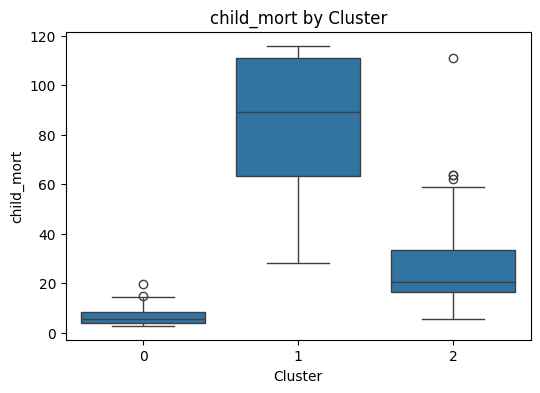

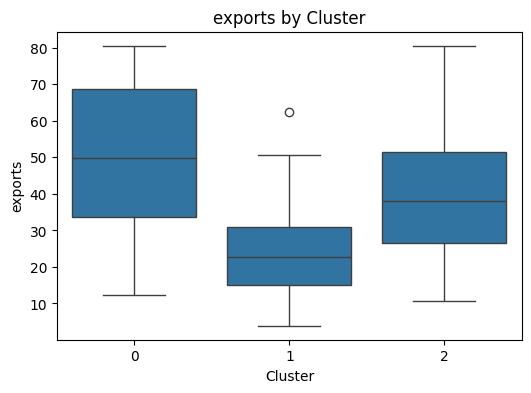

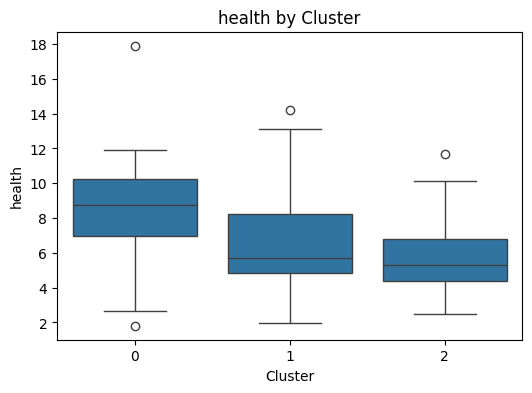

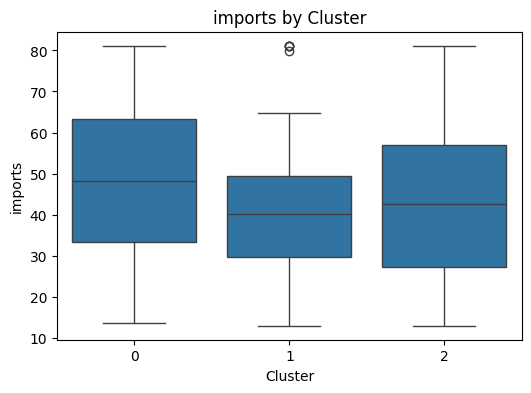

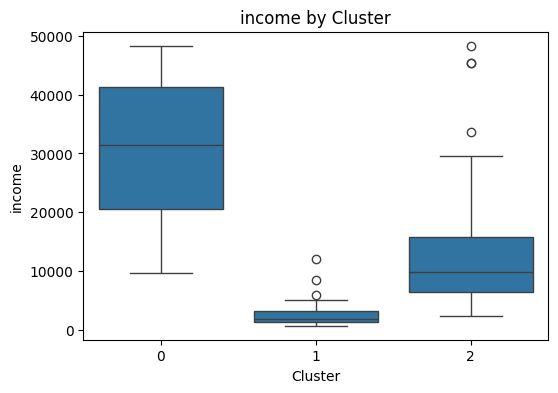

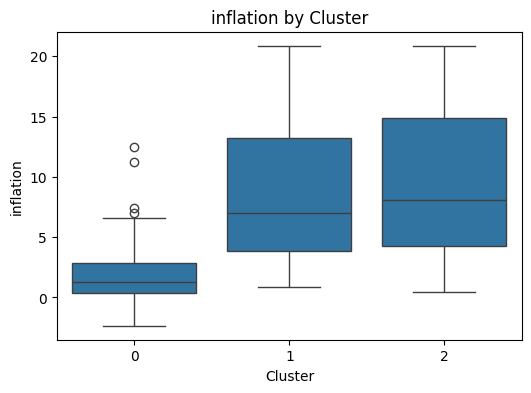

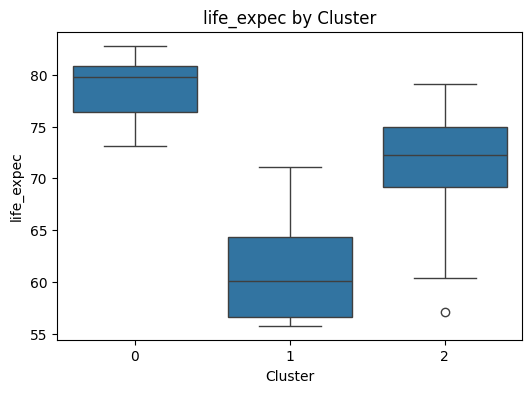

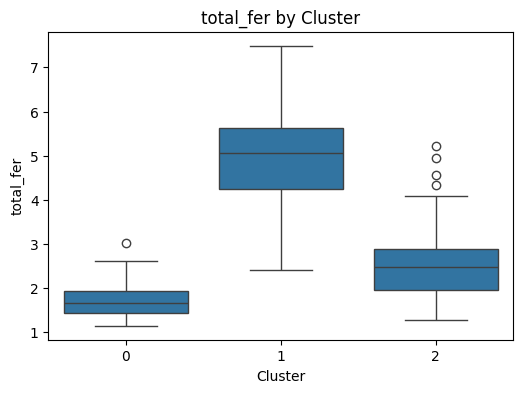

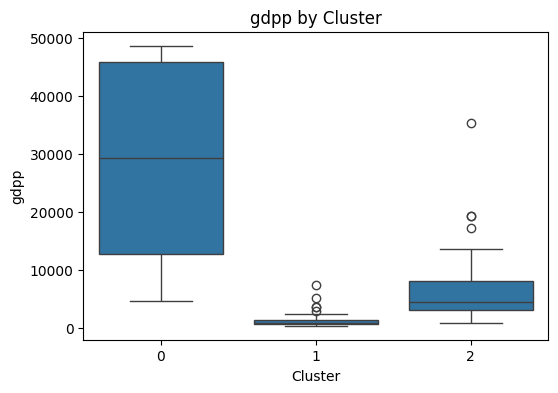

In [149]:
# Check the distribution of each Feature by cluster
features = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
for feat in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Cluster", y=feat, data=df)
    plt.title(f"{feat} by Cluster")
    plt.show()

In [150]:
# Compare means side by side

# Extract means of each cluster
mean_values = df.groupby("Cluster")[['income', 'gdpp']].mean()
print(mean_values)
# Transpose - rows: features, columns = cluster
mean_value_transposed = mean_values.T
print(mean_value_transposed)

               income          gdpp
Cluster                            
0        31258.148148  28540.185185
1         2513.159149   1223.090213
2        12461.969697   6140.212121
Cluster             0            1             2
income   31258.148148  2513.159149  12461.969697
gdpp     28540.185185  1223.090213   6140.212121


In [151]:
# Compare means side by side

# Extract means of each cluster
mean_values2 = df.groupby("Cluster")[['child_mort', 'exports', 'health', 'imports', 'inflation', 'life_expec', 'total_fer']].mean()
print(mean_values2)
# Transpose - rows: features, columns = cluster
mean_value_transposed2 = mean_values2.T
print(mean_value_transposed2)


         child_mort    exports    health    imports  inflation  life_expec  \
Cluster                                                                      
0          6.644444  50.167037  8.475370  49.811111   2.053193   78.679630   
1         85.640426  24.710826  6.575745  42.768255   9.136915   60.777021   
2         26.657576  40.318333  5.628636  43.244364   9.388197   71.651515   

         total_fer  
Cluster             
0         1.740556  
1         4.892128  
2         2.551364  
Cluster             0          1          2
child_mort   6.644444  85.640426  26.657576
exports     50.167037  24.710826  40.318333
health       8.475370   6.575745   5.628636
imports     49.811111  42.768255  43.244364
inflation    2.053193   9.136915   9.388197
life_expec  78.679630  60.777021  71.651515
total_fer    1.740556   4.892128   2.551364


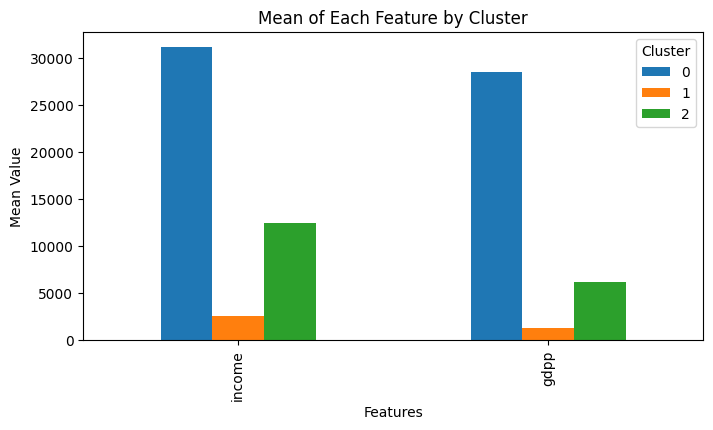

In [152]:
# plot tranposed 
mean_value_transposed.plot.bar(figsize=(8,4))
plt.title("Mean of Each Feature by Cluster")
plt.xlabel("Features")
plt.ylabel("Mean Value")
plt.show()

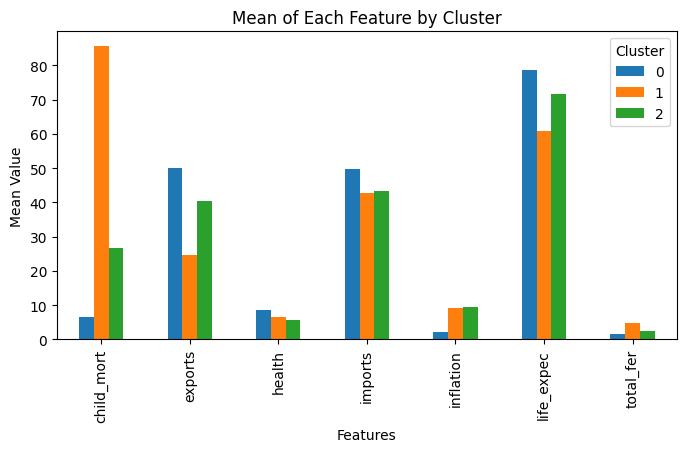

In [153]:
# plot tranposed 
mean_value_transposed2.plot.bar(figsize=(8,4))
plt.title("Mean of Each Feature by Cluster")
plt.xlabel("Features")
plt.ylabel("Mean Value")
plt.show()

In [154]:
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.20,5.82,553.0,1
1,Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.30,1.65,4090.0,2
2,Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.50,2.89,4460.0,2
3,Angola,116.0,62.3,2.85,42.9,5900.0,20.87,60.10,6.16,3530.0,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.80,2.13,12200.0,0
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950.0,2.62,63.00,3.50,2970.0,2
163,Venezuela,17.1,28.5,4.91,17.6,16500.0,20.87,75.40,2.47,13500.0,2
164,Vietnam,23.3,72.0,6.84,80.2,4490.0,12.10,73.10,1.95,1310.0,2
165,Yemen,56.3,30.0,5.18,34.4,4480.0,20.87,67.50,4.67,1310.0,1


In [155]:
# Filter countries in Cluster 1
cluster_1_countries = df[df["Cluster"] == 1]["country"]

cluster_1_countries

0                   Afghanistan
3                        Angola
17                        Benin
25                 Burkina Faso
26                      Burundi
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
40                Cote d'Ivoire
50                      Eritrea
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
66                        Haiti
80                        Kenya
81                     Kiribati
84                          Lao
87                      Lesotho
88                      Liberia
93                   Madagascar
94                       Malawi
97                         Mali
99                   Mauritania
101       Micronesia, Fed. Sts.
106                  Mozambique
107                     Myanmar
108                     Namibia
109                       Nepal
112     

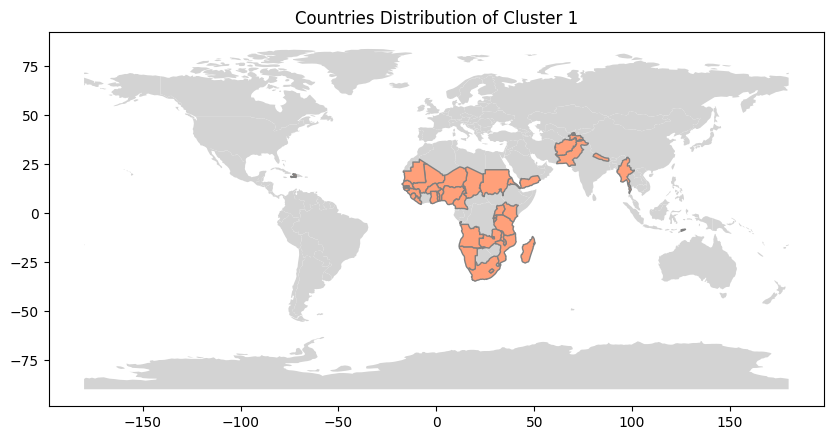

In [156]:
# Visualise the Countries Distribution of Cluster 1, which are the countries that HELP int. should focus on

# Download Natural Earth dataset manually
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/geojson/ne_110m_admin_0_countries.geojson")

# Filter world map to show only the countries in cluster_1_countries
selected_countries = world[world["NAME"].isin(cluster_1_countries.unique())]

# Plot the countries
fig, ax = plt.subplots(figsize=(10,10))
world.plot(ax=ax, color="lightgrey") 
selected_countries.plot(ax=ax, color='#FFA07A', edgecolor="grey")

plt.title("Countries Distribution of Cluster 1")
plt.show()



In [157]:
# Print out a list of all the countries in cluster 1
print(df[df["Cluster"] == 1]["country"].unique())

['Afghanistan' 'Angola' 'Benin' 'Burkina Faso' 'Burundi' 'Cameroon'
 'Central African Republic' 'Chad' 'Comoros' 'Congo, Dem. Rep.'
 "Cote d'Ivoire" 'Eritrea' 'Gambia' 'Ghana' 'Guinea' 'Guinea-Bissau'
 'Haiti' 'Kenya' 'Kiribati' 'Lao' 'Lesotho' 'Liberia' 'Madagascar'
 'Malawi' 'Mali' 'Mauritania' 'Micronesia, Fed. Sts.' 'Mozambique'
 'Myanmar' 'Namibia' 'Nepal' 'Niger' 'Nigeria' 'Pakistan' 'Rwanda'
 'Senegal' 'Sierra Leone' 'Solomon Islands' 'South Africa' 'Sudan'
 'Tajikistan' 'Tanzania' 'Timor-Leste' 'Togo' 'Uganda' 'Yemen' 'Zambia']


In [158]:
# Create cluster 1 df
cluster_1_df = df[df["Cluster"] == 1].reset_index(drop=True)
cluster_1_df= cluster_1_df.drop(columns='Cluster')
cluster_1_df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0000,7.58,44.900,1610.00,9.440,56.20,5.82,553.00
1,Angola,116.0,62.3000,2.85,42.900,5900.00,20.870,60.10,6.16,3530.00
2,Benin,111.0,23.8000,4.10,37.200,1820.00,0.885,61.80,5.36,758.00
3,Burkina Faso,116.0,19.2000,6.74,29.600,1430.00,6.810,57.90,5.87,575.00
4,Burundi,93.6,8.9200,11.60,39.200,764.00,12.300,57.70,6.26,331.62
5,Cameroon,108.0,22.2000,5.13,27.000,2660.00,1.910,57.30,5.11,1310.00
6,Central African Republic,116.0,11.8000,3.98,26.500,888.00,2.010,55.78,5.21,446.00
7,Chad,116.0,36.8000,4.53,43.500,1930.00,6.390,56.50,6.59,897.00
8,Comoros,88.2,16.5000,4.51,51.700,1410.00,3.870,65.90,4.75,769.00
9,"Congo, Dem. Rep.",116.0,41.1000,7.91,49.600,742.24,20.800,57.50,6.54,334.00


In [159]:
# Checking for null valuses in the new cluster 1 df
cluster_1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     47 non-null     object 
 1   child_mort  47 non-null     float64
 2   exports     47 non-null     float64
 3   health      47 non-null     float64
 4   imports     47 non-null     float64
 5   income      47 non-null     float64
 6   inflation   47 non-null     float64
 7   life_expec  47 non-null     float64
 8   total_fer   47 non-null     float64
 9   gdpp        47 non-null     float64
dtypes: float64(9), object(1)
memory usage: 3.8+ KB


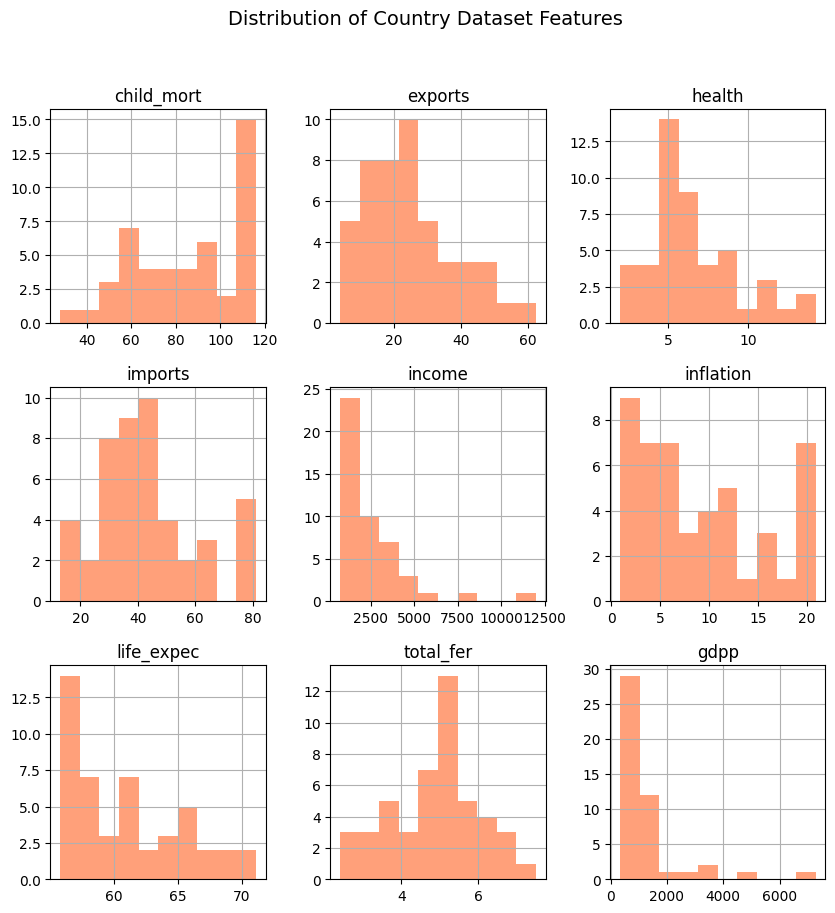

In [160]:
# Histogram of the dataset
cluster_1_df.hist(bins=10, color='#FFA07A', figsize=(10,10))

# Add title
plt.suptitle('Distribution of Country Dataset Features', fontsize=14)

plt.show()

# Hierartical Cluster of Cluster 1

## Narrow down the range of countries

In [161]:
# Standardising the data
scaler = StandardScaler()

features1 = cluster_1_df[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']]
data_norm = scaler.fit_transform(features1)
data_norm = pd.DataFrame(data_norm, columns=features1.columns)
data_norm.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.184410,-1.103797,0.355133,0.121214,-0.441514,0.047508,-1.041958,0.812134,-0.513368
1,1.227883,2.820428,-1.317527,0.007491,1.655675,1.839131,-0.154124,1.109724,1.767364
2,1.025659,-0.068342,-0.875492,-0.316619,-0.338855,-1.293467,0.232881,0.409512,-0.356314
3,1.227883,-0.413494,0.058085,-0.748767,-0.529508,-0.364738,-0.654953,0.855897,-0.496513
4,0.321922,-1.184833,1.776716,-0.202896,-0.855086,0.495806,-0.700483,1.197251,-0.682971


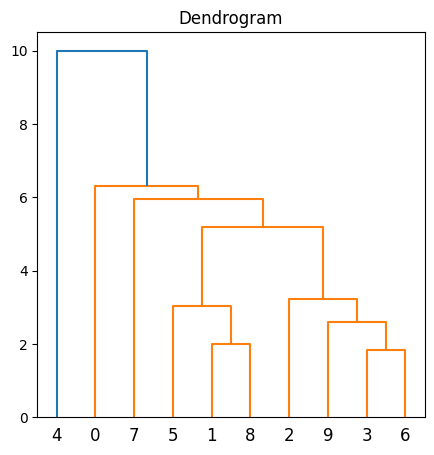

In [162]:
# Dendrogram to find the number of clusters
subset_data = data_norm.sample(n=10)

plt.figure(figsize=(5,5))
plt.title('Dendrogram')
dend = shc.dendrogram(shc.linkage(subset_data, method='ward'))
plt.show()

In [163]:
# Using sillhoute score to determine the k value

sil_score = []
k_range = range(2, 11)

for k in k_range:
    cluster = AgglomerativeClustering(n_clusters=k, metric= 'euclidean', linkage='ward')
    cluster_labels = cluster.fit_predict(data_norm)


    score = silhouette_score(data_norm, cluster_labels)
    sil_score.append(score)
    print(f'Sillohte score for k={k}: {score}')

Sillohte score for k=2: 0.17115119728823694
Sillohte score for k=3: 0.19431145905624664
Sillohte score for k=4: 0.2250701069794159
Sillohte score for k=5: 0.2195015168851288
Sillohte score for k=6: 0.17528203012103083
Sillohte score for k=7: 0.17964252342901885
Sillohte score for k=8: 0.17691309942628203
Sillohte score for k=9: 0.17794092477711407
Sillohte score for k=10: 0.18208041712343978


In [164]:
# Dimensionality reduction
pca = PCA(n_components=2)
reduced_data2 = pca.fit_transform(data_norm)

In [169]:
# Agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric= 'euclidean', linkage='ward')
y_predicted2 = clus.fit_predict(reduced_data2)

In [170]:
y_predicted2

array([2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 0, 1, 0, 0,
       2, 2, 2, 1, 0, 2, 1, 3, 0, 2, 1, 1, 0, 2, 2, 0, 3, 1, 0, 2, 1, 0,
       2, 1, 1])

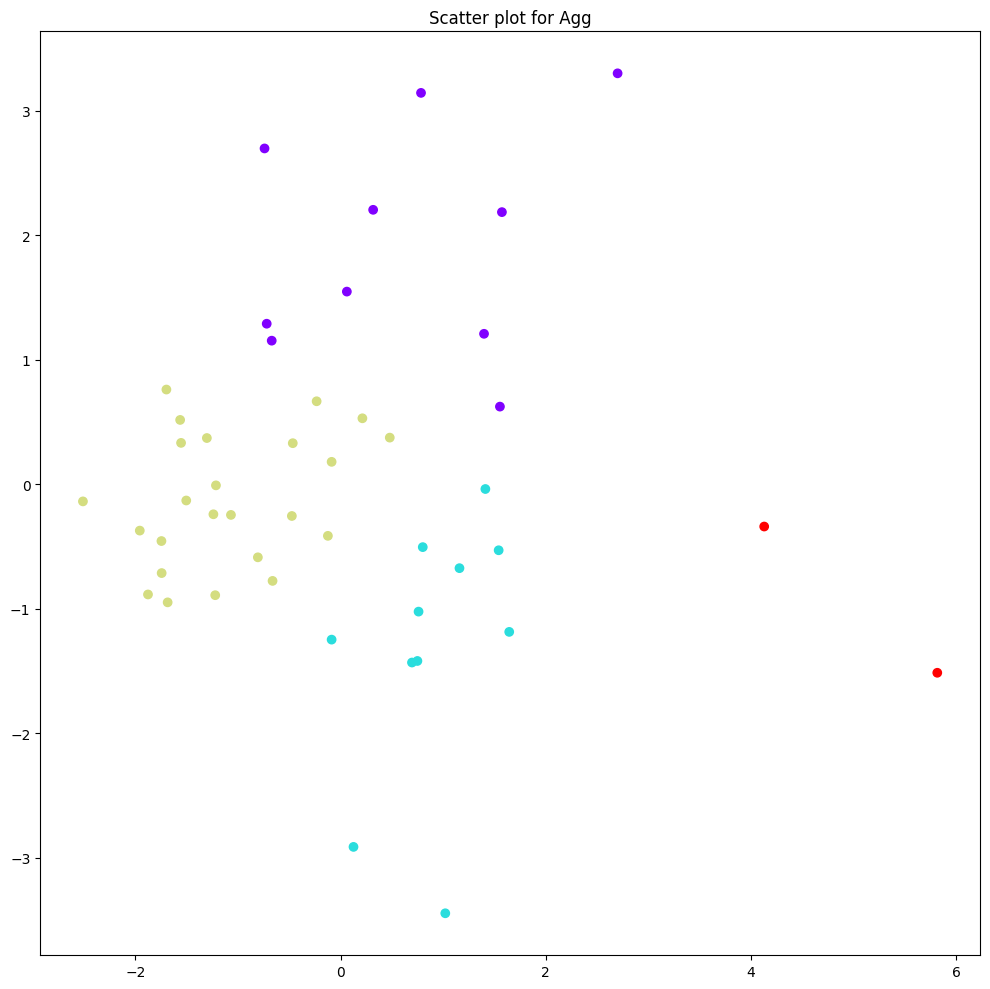

In [171]:
plt.figure(figsize=(10,10))
plt.scatter(x=reduced_data2[:, 0], y=reduced_data2[:, 1], c=y_predicted2, cmap='rainbow')
plt.title('Scatter plot for Agg')
plt.tight_layout()
plt.show()